<a href="https://colab.research.google.com/github/nicolasalarconl/InterferometryDeepLearning/blob/main/simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Params

**Imports**

In [196]:
# Simulated Images
from matplotlib import pyplot as plt
import numpy as np
import random
from astropy.io import fits
from astropy.utils.data import download_file
#Convolution 
from scipy import ndimage
# pytorch dataset 
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
#Deep Learning
import os
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import save_image
import cv2

**Params Images**

In [197]:
N = 28 # image size
N_PSF = 28 # psf size

**Params Elipses**

In [198]:

MIN_VALUE_INTENSITY = 0.6 #TODO: comentar
MAX_VALUE_INTENSITY = 0.99  #TODO: comentar

MIN_A = N*0.05  #5% of image width     #minimum value of the semi-minor axis (a)
MAX_A = N*0.15  #15%  of image width   #maximum value of the semi-minor axis (a)
STEP_A =  0.01  #step between the maximum and minimum value range of (a)


MIN_B = N*0.05  #5% of image length    #minimum value of the semi-major axis (b)
MAX_B = N*0.15  #15% of image length   #maximum value of the semi-major axis (b)
STEP_B = 0.01   #step between the maximum and minimum value range of (b)

MOV_X = N*0.1 #(+/-10%)   #maximum movement in the x-axis (positive and negative) with respect to the center of the image
STEP_X = 1 #step between the maximum and minimum value range of the movement in the x-axis


MOV_Y = N*0.1 #(+/-10%)   #maximum movement in the y-axis (positive and negative) with respect to the center of the image
STEP_Y = 1 #step between the maximum and minimum value range of the movement in the y-axis

ANGLE_MIN = -np.pi #TODO:comentar
ANGLE_MAX=   np.pi #TODO:comentar
STEP_ANGLE = 0.1 #TODO:comentar

SIGMA_MIN = 0  #TODO:comentar
SIGMA_MAX = 1#TODO:comentar
STEP_SIGMA  = 0.1 #TODO:comentar



**Params Simulated Image**

In [199]:
N_ELLIPSES_RANDOM = 100 #Number of ellipses created randomly
N_ELLIPSES_OPERATION = round(N_ELLIPSES_RANDOM*0.1) #10% of the list  of ellipses #Number of ellipses to operate to create a simulated image
PERC_INFO = 0.04  # 4% #percentage of information in an image, so that it is considered valid

**Params Dataset Save**

In [200]:
PATH_SAVE = 'images_simulated' #path where the dataset is saved
INITIAL_SAVE = 0 #initial index for the names of the generated images 
FINAL_SAVE = 5000 #final index for the names of the generated images 

**Params Dataset Read**

In [201]:
PATH_READ = 'images_simulated' #path where the dataset is saved 
INITIAL_READ = 0   #initial index for the names of the saved images 
FINAL_READ = 5000  #final index for the names of the saved images 

**Params Dataset Python**


In [202]:
PATH = 'images_simulated' #path where the dataset is saved 
INITIAL_DATASET = 0  #initial index for the names of the saved images 
FINAL_DATASET = 5000  #final index for the names of the saved images 
PERC_TRAIN = 0.7 # (70%) #training percentage 
PERC_TEST =  0.3 # (30%) #testing percentag
BATCH = 8 #batch size

**Params Deep Learning**

In [203]:
# constants
NUM_EPOCHS = 40
LEARNING_RATE = 1e-3
PATH_TRAIN = 'train'
PATH_TEST = 'test'
SIZE_IMAGES = 28

**Auxiliary functions**

Function which makes a directory `path`.

In [204]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Simuted Images



**Create Ellipse**


* `n`: image size
* `a`: exe semi-minor axis
* `b`: semi-major axis
* `min`: TODO: Comentar
* `max`: TODO: Comentar
* `mov_x`: movement in the x-axis with respect to the center of the image
* `mov_y`: movement in the y-axis with respect to the center of the image
* `angle`: angle around
* `sigma`: TODO: Comentar



 






In [205]:
def create_elipse(n,a,b,min,max,mov_x,mov_y,angle,sigma):
  X=np.reshape(np.arange(0,n),(1,n))
  Y=np.reshape(np.arange(0,n), (n,1)) 
  X=X-n/2 + mov_x
  Y=Y-n/2 + mov_y
  c=np.cos(angle)
  s=np.sin(angle)
  XX=X*c + Y*s # para no sobre-escribir X
  YY=X*s - Y*c
  X=XX
  Y=YY
  Z=np.sqrt(((X/a)**2+((Y/b)**2)))
  Z= np.exp(-Z**2/2/sigma**2)
  ZZ =np.copy(Z)
  Z[ZZ<min]=0
  Z[ZZ>max]=0
  return Z

Example

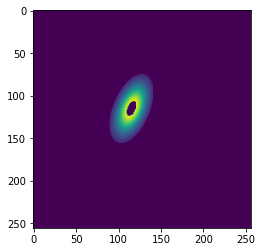

In [206]:
n = 256 # image 256x256
a = 20 # eje semi-minor
b = 40 # eje semi-major
min= 0.1  # TODO: comentar
max = 0.9 # TODO: comentar
mov_x = n*0.05 #5% to the right of the center of the image
mov_y = n*0.05 #5% up from the center of the image 
angle = 2*np.pi*(1/16.0) # (45º angle around)
sigma = 0.5 # TODO: comentar

elipse = create_elipse(n,a,b,min,max,mov_x,mov_y,angle,sigma)
plt.imshow(elipse)

**Random Ellipses**

For each of the ellipse parameters we generate a list of all the values ​​that they can take.

*   `a_list`: list of all possible values ​​that of semi-minor axis `a`
*   `b_list`: list of all possible values of semi-major axis  `b` 
*   `mov_x_list`: TODO: Esto no es asi lista de desplazamientos con respecto al centro de la elipse en el plano x 
*   `mov_y_list`:   TODO: Esto no es asi  lista de desplazamientos con respecto al centro de la elipse en el plano y 
*   `angle_list`:   TODO: comentar
*   `sigma_list`:  TODO: comentar






In [207]:
a_list = np.arange(MIN_A,MAX_A,STEP_A)
b_list = np.arange(MIN_B,MAX_B,STEP_B)
mov_x_list = np.arange(-MOV_X,MOV_X,STEP_X)
mov_y_list = np.arange(-MOV_Y,MOV_Y,STEP_Y)
angle_list=  np.arange(ANGLE_MIN,ANGLE_MAX,STEP_ANGLE)
sigma_list = np.arange(SIGMA_MIN,SIGMA_MAX,STEP_ANGLE)


now, we generate a random value of each parameter of an ellipse



In [208]:
def random_params(a_list,b_list,mov_x_list,mav_y_list,angle_list,sigma_list):
  a  = random.choice(a_list)
  b  = random.choice(b_list)
  x = random.choice(mov_y_list)
  y = random.choice(mov_y_list)
  an = random.choice(angle_list) 
  sig = random.choice(sigma_list)
  return [a,b,x,y,an,sig]

Example

<Figure size 432x288 with 0 Axes>

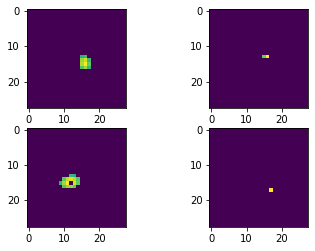

In [209]:
params_1 = random_params(a_list,b_list,mov_x_list,mov_y_list,angle_list,sigma_list)
params_2 = random_params(a_list,b_list,mov_x_list,mov_y_list,angle_list,sigma_list)
params_3 = random_params(a_list,b_list,mov_x_list,mov_y_list,angle_list,sigma_list)
params_4 = random_params(a_list,b_list,mov_x_list,mov_y_list,angle_list,sigma_list)

ellipse_1 = create_elipse(N,params_1[0],params_1[1],MIN_VALUE_INTENSITY,MAX_VALUE_INTENSITY,params_1[2],params_1[3],params_1[4],params_1[5])
ellipse_2 = create_elipse(N,params_2[0],params_2[1],MIN_VALUE_INTENSITY,MAX_VALUE_INTENSITY,params_2[2],params_2[3],params_2[4],params_2[5])
ellipse_3 = create_elipse(N,params_3[0],params_3[1],MIN_VALUE_INTENSITY,MAX_VALUE_INTENSITY,params_3[2],params_3[3],params_3[4],params_3[5])
ellipse_4 = create_elipse(N,params_4[0],params_4[1],MIN_VALUE_INTENSITY,MAX_VALUE_INTENSITY,params_4[2],params_4[3],params_4[4],params_4[5])

plt.figure()
f, axarr=plt.subplots(2,2)
axarr[0,0].imshow(ellipse_1)
axarr[0,1].imshow(ellipse_2)
axarr[1,0].imshow(ellipse_3)
axarr[1,1].imshow(ellipse_4)


**List of random Ellipses**



We generate a list of random ellipses, of size `N_RANDOM_ELIPSES`




In [210]:
def create_ellipses(n_ellipses,a_list,b_list,mov_x_list,mov_y_list,angle_list,sigma_list):
  elipses = []
  for i in range(0,n_ellipses):
    params = random_params(a_list,b_list,mov_x_list,mov_y_list,angle_list,sigma_list)
    elipse= create_elipse(N,params[0],params[1],MIN_VALUE_INTENSITY,MAX_VALUE_INTENSITY,params[2],params[3],params[4],params[5])
    elipses.append(elipse)
  return elipses
  
list_elipses = create_ellipses(N_ELLIPSES_RANDOM,a_list,b_list,mov_x_list,mov_y_list,angle_list,sigma_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


now we visualize 4 images of the generated ellipse list

<Figure size 432x288 with 0 Axes>

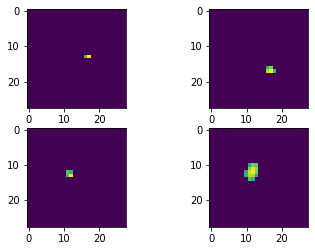

In [211]:
list_random_elipses = random.sample(list_elipses, 4)
plt.figure()
f, axarr=plt.subplots(2,2)
axarr[0,0].imshow(list_random_elipses[0])
axarr[0,1].imshow(list_random_elipses[1])
axarr[1,0].imshow(list_random_elipses[2])
axarr[1,1].imshow(list_random_elipses[3])


**Image information percentage**

Finally, to simulate the interferometric image, we will make a combination of ellipses through mathematical operations.

To avoid that the generated image is empty or contains very little information, we created a function that allows us to calculate the percentage of information

In [212]:
def get_perc_info(image):
   n = len(image)
   c = np.sum(image>0)  
   perc=(c)/(n*n)
   return perc

we also create a function to normalize the created image

In [213]:
def normalize(image):
  image = image - np.min(image)
  image = image/np.max(image)
  return image



*   `list_elipses`: list containing all possible ellipses to combine
*   `size_subsets`: number of ellipses to combine

Using these parameters we generate a random subset of `list_elipses` called` list_random_elipses`. We obtain the first element of this subset and perform a mathematical operation (obtained randomly from the list of `operators`) with the next ellipse in the list, then the generated figure is operated with the next element in the list of subsets.


In [214]:
def random_figure(list_elipses,size_subset):
  size = len(list_elipses)
  if (size_subset > size):
    size_subset = size
  operators = ['*','+','-']
  list_random_elipses = random.sample(list_elipses, size_subset)
  final_figure = list_random_elipses[random.randrange(0,size_subset-1,1)]
  for elipse in list_random_elipses:
    operator =random.choice(operators)
    if (operator == '+'):
      final_figure = elipse + final_figure
    elif (operator == '*'):
      final_figure = elipse * final_figure
    elif (operator == '-'):
      final_figure = elipse - final_figure
  final_figure_copy  = np.copy(final_figure)
  final_figure = normalize(final_figure)
  final_figure[final_figure_copy ==0]=0
  if (get_perc_info(final_figure) > PERC_INFO):
    #ZZ =np.copy(final_figure)
    #final_figure[ZZ<MIN_VALUE_INTENSITY]=0
    #final_figure[ZZ>MAX_VALUE_INTENSITY]=0
    return final_figure
  else:
    return random_figure(list_elipses,size)

Example

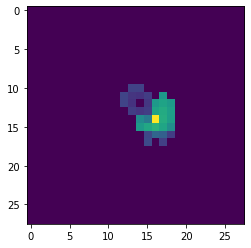

In [215]:
figure = random_figure(list_elipses,N_ELLIPSES_OPERATION)
plt.imshow(figure)

**CREATE AND SAVE DATASET SIMULATED IMAGES IN FITS FORMAT**

*   `initial`: initial index for the names of the generated images
*   `final`: final index for the names of the generated images
*   `list_elipses`: list of ellipses
*   `path`: path where the images are saved



In [216]:
def dataset_figures(initial,final,list_elipses,path):
  dataset = []
  size_ellipse = len(list_elipses[0])
  for index in range(initial,final):
    if (index%100 ==0):
      print(index)
    figure = random_figure(list_elipses,N_ELLIPSES_OPERATION)
    hdu_image =fits.PrimaryHDU(figure)
    hdu_image.writeto(path+'/image_'+str(size_ellipse)+'x'+str(size_ellipse)+'_'+str(index)+'.fits',clobber=True)
    dataset.append(figure)
  return dataset

Example

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


<Figure size 432x288 with 0 Axes>

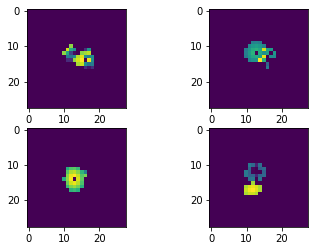

In [217]:
make_dir(PATH_SAVE)
simulted_images = dataset_figures(INITIAL_SAVE,FINAL_SAVE,list_elipses,PATH_SAVE)
list_random_dataset = random.sample(simulted_images, 4)
plt.figure()
f, axarr=plt.subplots(2,2) 
axarr[0,0].imshow(list_random_dataset[0])
axarr[0,1].imshow(list_random_dataset[1])
axarr[1,0].imshow(list_random_dataset[2])
axarr[1,1].imshow(list_random_dataset[3])


**READ DATASET FITS FORMAT**

display fit image from a directory

In [218]:
def display_fits(path):
  hdul=fits.open(path)
  hdr = hdul[0].header
  size = hdr[3]
  data = hdul[0].data.astype(np.float32)
  image = np.reshape(data,[size,size])
  plt.imshow(image)

read fit image dataset from a directory


*   `path`: path where the images are
*   `type_image`: *image* (simulated images) or *conv* (dirty images)
*   `size_image`: TODO: comentar
*   `initial`: initial index for the names of the saved images
*   `final`: final index for the names of the saved images



In [219]:
def get_dataset(path,type_image,size_image,initial,final):
  images = []
  path_file = path+'/'+type_image+'_'+str(size_image)+'x'+str(size_image)+'_'+str(initial)+'.fits'
  #hdul=fits.open(path_file)  
  #hdr = hdul[0].header
  #size = hdr[3]
  for i in range(initial,final):
    path_file = path+'/'+type_image+'_'+str(size_image)+'x'+str(size_image)+'_'+str(i)+'.fits'
    hdul=fits.open(path_file)
    data = hdul[0].data.astype(np.float32)
    image = np.reshape(data,[size_image,size_image])
    images.append(image)
  return images

Example: Read dataset simulated images

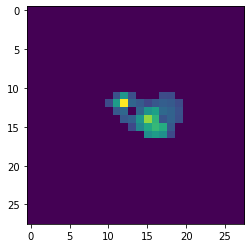

In [220]:
simulted_images = get_dataset(PATH_SAVE,'image',N,INITIAL_READ,FINAL_READ)
simulated_image_random  = random.choice(simulted_images)
plt.imshow(simulated_image_random)

# PSF 

In [221]:
def info_fit_path(path):
   image_link = download_file(path, cache=True )
   hdu_list = fits.open(image_link)
   hdu_list.info()

In [222]:
def getdata_fit_path(path):
  image_link = download_file(path, cache=True )
  image = fits.getdata(image_link).astype(np.float32)
  image = np.reshape(image,[image.shape[2],image.shape[3]])
  return image

**PSF real 128x128**

Filename: /root/.astropy/cache/download/url/423d062de61cc8a03c5869b3ab47e189/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (128, 128, 1, 1)   float32   


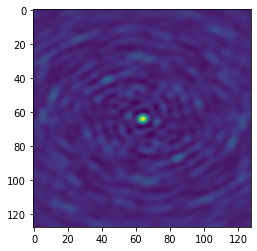

In [223]:
url_128x128 = 'https://github.com/nicolasalarconl/InterferometryDeepLearning/blob/main/4_hd142_128x128_08.psf.fits?raw=true'
psf_128x128 = getdata_fit_path(url_128x128)
plt.imshow(psf_128x128)
info_fit_path(url_128x128)

**PSF Gaussian**

In [224]:
def gauss(tamX,tamY,div):
  x, y = np.meshgrid(np.linspace(-1,1,tamX), np.linspace(-1,1,tamY))
  d = np.sqrt(x*x+y*y)
  sigma, mu = 1/div, 0.0
  gauss = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
  return gauss


Example PSF Gauss 128x128

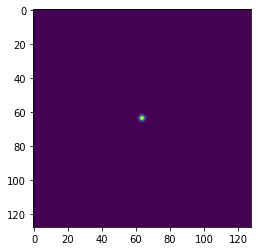

In [225]:
psf_gauss_128x128 =gauss(128,128,64)
plt.imshow(psf_gauss_128x128)

Example PSF Gauss 28x28

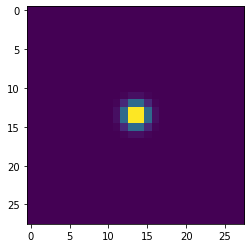

In [226]:
psf_gauss_28x28 =gauss(28,28,14)
plt.imshow(psf_gauss_28x28)

# Dirty Images

**Params**

In [227]:
DATASET_SIMULTED_IMAGES = get_dataset(PATH_READ,'image',N,INITIAL_READ,FINAL_READ)
PSF = psf_gauss_28x28

**Auxiliary functions**

In [228]:
### display two images
def display_two(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display one image
def display(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.show()

**Convolution: PSF 128x128 cell 0.8 - Simulated Image**


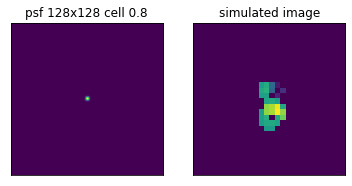

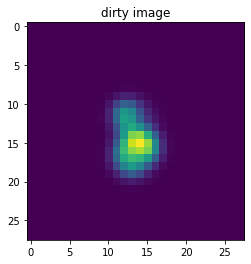

In [229]:
simulated_image_random  = random.choice(simulted_images)
display_two(psf_gauss_128x128,simulated_image_random,title1="psf 128x128 cell 0.8",title2="simulated image")
conv_128x128_08 = ndimage.convolve(simulated_image_random,psf_gauss_128x128,mode='constant', cval=0.0)
display(conv_128x128_08,"dirty image")

**Convolution: PSF 128x128 - 3 Random Simulated Image**

<Figure size 432x288 with 0 Axes>

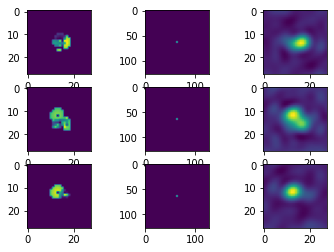

In [230]:
simulated_images_random =  random.sample(simulted_images, 3)
random_1_conv_128x128 = ndimage.convolve(simulated_images_random[0],psf_128x128,mode='constant', cval=0.0)
random_2_conv_128x128 = ndimage.convolve(simulated_images_random[1],psf_128x128,mode='constant', cval=0.0)
random_3_conv_128x128 = ndimage.convolve(simulated_images_random[2],psf_128x128,mode='constant', cval=0.0)

plt.figure()
f, axarr=plt.subplots(3,3)
axarr[0,0].imshow(simulated_images_random[0])
axarr[0,1].imshow(psf_gauss_128x128)
axarr[0,2].imshow(random_1_conv_128x128)
axarr[1,0].imshow(simulated_images_random[1])
axarr[1,1].imshow(psf_gauss_128x128)
axarr[1,2].imshow(random_2_conv_128x128)
axarr[2,0].imshow(simulated_images_random[2])
axarr[2,1].imshow(psf_gauss_128x128)
axarr[2,2].imshow(random_3_conv_128x128)

**Convolution: PSF Gaus 128x128- Simulated Image**

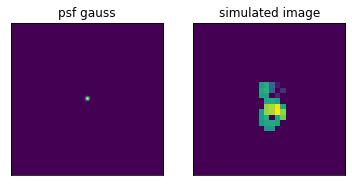

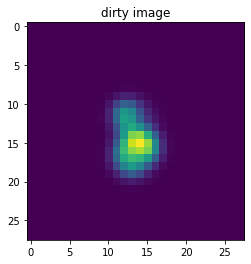

In [231]:
display_two(psf_gauss_128x128,simulated_image_random,title1="psf gauss",title2="simulated image")
conv_gauss = ndimage.convolve(simulated_image_random,psf_gauss_128x128,mode='constant', cval=0.0)
display(conv_gauss,"dirty image")

**Convolution: PSF Gaus 28x28- Simulated Image**

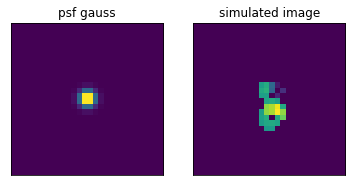

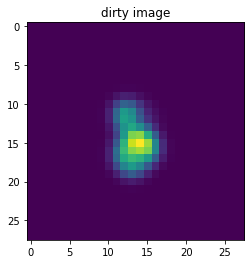

In [232]:
display_two(psf_gauss_28x28,simulated_image_random,title1="psf gauss",title2="simulated image")
conv_gauss = ndimage.convolve(simulated_image_random,psf_gauss_28x28,mode='constant', cval=0.0)
display(conv_gauss,"dirty image")

**CREATE AND SAVE DIRTY IMAGES**



*  `psf`: point spread function to convolve 
*  `psf_name`: label psf
*  `images`: simulated image to convolve
*  `path`: path where convolved images will be saved



In [233]:
def dataset_dirty(psf,images,path):
  dataset = []
  index = 0
  size_psf = len(psf)
  c  = 0
  for image in images:
    if (c%100 ==0):
      print(c)
    c = c +1
    conv = ndimage.convolve(image,psf,mode='constant', cval=0.0)
    hdu_image =fits.PrimaryHDU(conv)
    hdu_image.writeto(path+'/conv_'+str(size_psf)+'x'+str(size_psf)+'_'+str(index)+'.fits',clobber=True)
    dataset.append(conv)
    index = index + 1 
  return dataset

Example

0


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


<Figure size 432x288 with 0 Axes>

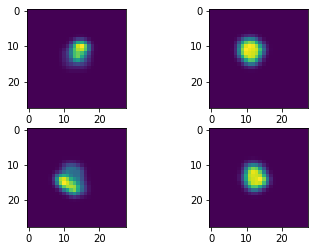

In [234]:
dirty_images = dataset_dirty(PSF,DATASET_SIMULTED_IMAGES,PATH_SAVE)
list_random_dirty = random.sample(dirty_images, 4)
plt.figure()
f, axarr=plt.subplots(2,2)
axarr[0,0].imshow(list_random_dirty[0])
axarr[0,1].imshow(list_random_dirty[1])
axarr[1,0].imshow(list_random_dirty[2])
axarr[1,1].imshow(list_random_dirty[3])

Read dataset dirty images

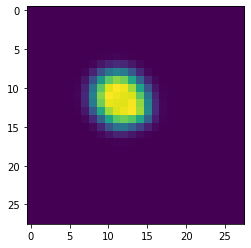

In [235]:
dirty_images = get_dataset(PATH_READ,'conv',N_PSF,INITIAL_READ,FINAL_READ)
dirty_image_random  = random.choice(dirty_images)
plt.imshow(dirty_image_random)

# Pytorch Dataset

**Params**

In [236]:
size = FINAL_DATASET- INITIAL_DATASET  #size of lot of the dataset
size_train = round(size*PERC_TRAIN) 
size_test =  round(size*PERC_TEST)  
batch_size=  BATCH 
data_image = get_dataset(PATH,'image',N,INITIAL_DATASET,FINAL_DATASET)
data_dirty  = get_dataset(PATH,'conv',N_PSF,INITIAL_DATASET,FINAL_DATASET)

TODO: Comentar como en tutorial (DATAset create)

In [237]:
class interferometryDataset(Dataset):
  def __init__(self,datasetnoised,datasetclean,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    
    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)

    return (xNoise,xClean)

we define the transforms for the images of dataset.

In [238]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

we divide the images into training and test sets

In [239]:
train_dirty = data_dirty[0:size_train]
train_images = data_image[0:size_train]

test_dirty = data_dirty[size_train:size_train+size_test]
test_image = data_image[size_train:size_train+size_test]

we generate the dataset using `Dataloard` that eases the task of making iterable training and testing sets. 

In [240]:
trainset=interferometryDataset(train_dirty,train_images,tsfms)
testset=interferometryDataset(test_dirty,test_image,tsfms)
trainloader=DataLoader(trainset,batch_size,shuffle=True)
testloader=DataLoader(testset,batch_size,shuffle=True)

# Deep Learning

**Auxiliary functions**

returns the CUDA GPU device or the CPU depending upon the availability. 

In [241]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

TODO: Comentar

In [242]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

TODO: Comentar

In [243]:
# the autoencoder network
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3)
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.sigmoid(self.out(x))
        return x
net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1))
)


In [244]:
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [245]:
def train(net, trainloader, NUM_EPOCHS,path):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for dirty,clean in tqdm((trainloader)):
            #dirty=np.clip(dirty, 0., 1.)
            #clean=np.clip(clean, 0., 1.)
            dirty,clean=dirty.to(device),clean.to(device)
            print(dirty.shape)
            print(clean.shape)
            optimizer.zero_grad()            
            outputs = net(dirty)
            print(dirty)
            loss = criterion(outputs, clean)
            # backpropagation
            loss.backward()
            # update the parameters
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        save_decoded_image(dirty.cpu().data, name='./'+path+'/noisy{}.png'.format(epoch))
        save_decoded_image(outputs.cpu().data, name='./'+path+'/denoised{}.png'.format(epoch))
        save_decoded_image(clean.cpu().data, name='./'+path+'/clean{}.png'.format(epoch))
    return train_loss

In [246]:
def test_image_reconstruction(net, testloader,path):
  pnsr_1_list = []
  pnsr_2_list = []
  pnsr_3_list = []
  cout = 0
  for dirty,clean in tqdm((testloader)):
    dirty,clean=dirty.to(device),clean.to(device)
    output = net(dirty)
    output = output.cpu().data
    clean = clean.cpu().data
    dirty = dirty.cpu().data
    psnr_1 = cv2.PSNR(np.array(clean), np.array(output))
    psnr_2 = cv2.PSNR(np.array(clean), np.array(dirty))
    psnr_3 = cv2.PSNR(np.array(dirty), np.array(output))
    pnsr_1_list.append(psnr_1)
    pnsr_2_list.append(psnr_2)
    pnsr_3_list.append(psnr_3)
    save_decoded_image(dirty.cpu().data, name='./'+path+'/noisy{}.png'.format(count))
    save_decoded_image(outputs.cpu().data, name='./'+path+'/denoised{}.png'.format(v))
    save_decoded_image(clean.cpu().data,  name='./'+path+'/clean{}.png'.format(count))
    count = count+1 
  return [pnsr_1_list,pnsr_2_list,pnsr_3_list]

In [247]:
device = get_device()
print(device)
net.to(device)

# test_image_reconstruction(net, train_test)

cuda:0


Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1))
)

In [248]:
make_dir(PATH_TRAIN)
train_loss = train(net, trainloader, NUM_EPOCHS,PATH_TRAIN)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('./Saved_Images/conv_ae_fahsionmnist_loss.png')

  0%|          | 0/438 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([8, 1, 28, 28])) that is different to the input size (torch.Size([8, 1, 26, 26])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/438 [00:00<?, ?it/s]

torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0

RuntimeError: ignored

In [ ]:
make_dir(PATH_TEST) 
psnr_1_2_3 = test_image_reconstruction(net, testloader,PATH_TEST)

In [ ]:
plt.hist(psnr_1_2_3[0],  linewidth=1, label ='clean-output')
plt.hist(psnr_1_2_3[1],  linewidth=1, label = 'clean-dirty')
plt.hist(psnr_1_2_3[2], linewidth=1, label = 'dirty-output')
plt.legend(loc='upper right')
plt.show()


